## 0. Import Libraries

In [17]:
import glob
import cartopy

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## 1. Define Parameters

In [62]:
# general data path
general_path = 'data'

# variable name
name_var = 'TOT_PREC'

# model and observation source names
name_model = 'cosmo'
name_obs = 'era5land'

# data aggregation type
type_agg = 'monsum'

# data time information
ref_interval = np.arange(1985, 2006) # including 1985 and 2006
ref_first = ref_interval[0]
ref_last = ref_interval[-1]

# reference data paths
common_path = fr'{general_path}/{name_var}'
path_model = fr'{common_path}/{name_model}/{name_model}_{type_agg}_{ref_first}_{ref_last}.nc'
path_obs = fr'{common_path}/{name_obs}/{name_obs}_{type_agg}_{ref_first}_{ref_last}.nc'

## 2. Open Data

### 2.1 Projection Data

In [14]:
# open data to fetch projection from
dt_proj = xr.open_dataset(r'data/lffd2100123118.nc')

### 2.2 Model Data

In [3]:
# open model data
dt_model = xr.open_dataset(path_model, engine='netcdf4')

### 2.3 Observation Data

In [66]:
# open observation data
dt_obs = xr.open_dataset(path_obs, engine='netcdf4')

In [67]:
dt_obs

<xarray.Dataset>
Dimensions:    (longitude: 121, latitude: 81, time: 252)
Coordinates:
  * longitude  (longitude) float32 20.0 20.25 20.5 20.75 ... 49.5 49.75 50.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 1985-01-01 1985-02-01 ... 2005-12-01
Data variables:
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-11-24 13:36:30 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [68]:
# rename precipitation variable for observation
dt_obs = dt_obs.rename({'tp':name_var})

## 3. Assign Projection

In [69]:
# define globe
globe = cartopy.crs.Globe(ellipse='sphere',
                          semimajor_axis=6370000,
                          semiminor_axis=6370000)

### 3.1 Model Data

In [70]:
# fetch model projection info
rotated_pole = dt_proj['rotated_pole']
pole_longitude = rotated_pole.attrs['grid_north_pole_longitude']
pole_latitude = rotated_pole.attrs['grid_north_pole_latitude']

In [71]:
# define model projection
proj_model = cartopy.crs.RotatedPole(pole_longitude=pole_longitude,
                               pole_latitude=pole_latitude,
                               globe=globe
                               )
proj_model.proj4_params

{'ellps': 'sphere',
 'a': 6370000,
 'b': 6370000,
 'proj': 'ob_tran',
 'o_proj': 'latlon',
 'o_lon_p': 0.0,
 'o_lat_p': 50.0,
 'lon_0': 33.0,
 'to_meter': 111177.4733520388}

In [72]:
# write projection
dt_model = dt_model.rio.write_crs(proj_model)

In [73]:
dt_model.rio.crs

CRS.from_wkt('GEOGCRS["unnamed",BASEGEOGCRS["unknown",DATUM["unknown",ELLIPSOID["unknown",6370000,0,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],DERIVINGCONVERSION["unknown",METHOD["PROJ ob_tran o_proj=latlon"],PARAMETER["o_lon_p",0,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],PARAMETER["o_lat_p",50,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],PARAMETER["lon_0",33,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]],CS[ellipsoidal,2],AXIS["longitude",east,ORDER[1],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],AXIS["latitude",north,ORDER[2],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]]')

### 3.2 Observation Data

In [74]:
# define observation projection
proj_obs = cartopy.crs.CRS('EPSG:4326',
                          )
proj_obs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [75]:
# write projection
dt_obs = dt_obs.rio.write_crs(proj_obs)

In [76]:
dt_obs.rio.crs

CRS.from_epsg(4326)

## 4.Calculate Climatologies

### 4.1 Monthly Mean

#### 4.1.1 Model Data

In [84]:
dt_obs_monmean_clim = dt_obs.groupby('time.month').mean()*1e3 # m to mm

#### 4.1.2 Observation Data

In [85]:
dt_model_monmean_clim = dt_model.groupby('time.month').mean() # already mm (kgm**s-2)

### 4.2 Seasonally Mean

#### 4.2.1 Model Data

In [86]:
dt_obs_seasonmean_clim = dt_obs.groupby('time.season').mean()*1e3 # m to mm

#### 4.2.2 Observation Data

In [87]:
dt_model_seasonmean_clim = dt_model.groupby('time.season').mean() # already mm (kgm**s-2)

### 4.3 Annual Mean

#### 4.3.1 Model Data

In [88]:
dt_obs_annualmean_clim = dt_obs.groupby('time.year').mean()*1e3 # m to mm

#### 4.3.2 Observation Data

In [89]:
dt_model_annualmean_clim = dt_model.groupby('time.year').mean() # already mm (kgm**s-2)

## 5. Quick Look Over Data

### 5.1 Model Data

#### 5.1.1 Monthly Mean

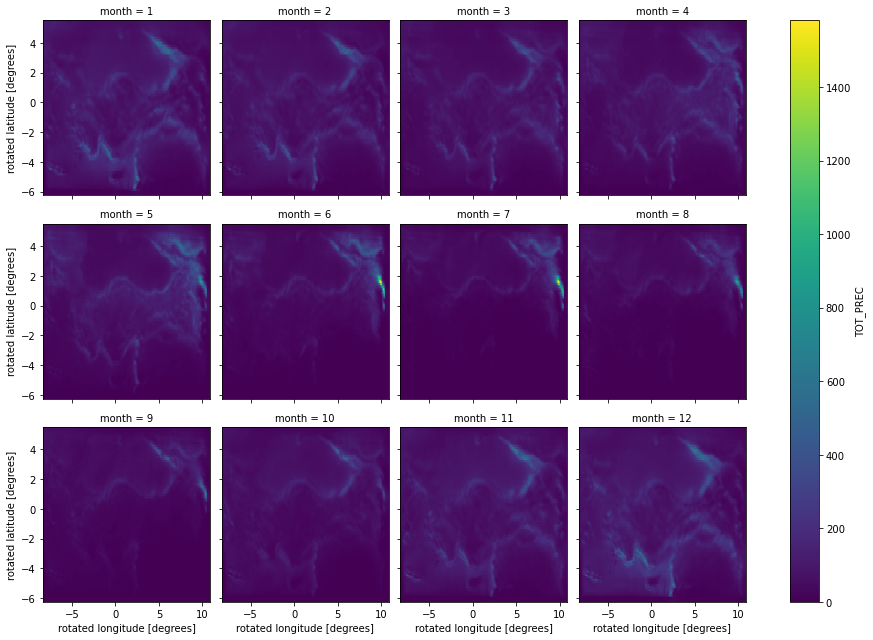

In [98]:
dt_model_monmean_clim[name_var].plot(col='month',
                                   col_wrap=4)

#### 5.1.2 Seasonally Mean

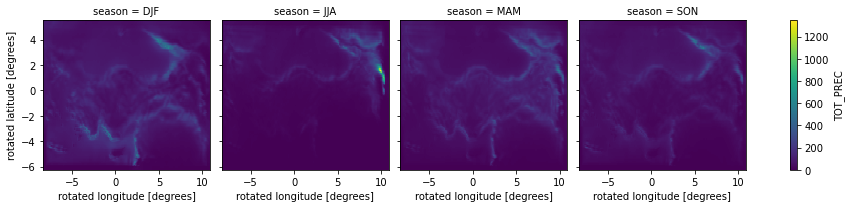

In [99]:
dt_model_seasonmean_clim[name_var].plot(col='season',
                                      col_wrap=4)

#### 5.1.3 Annual Mean

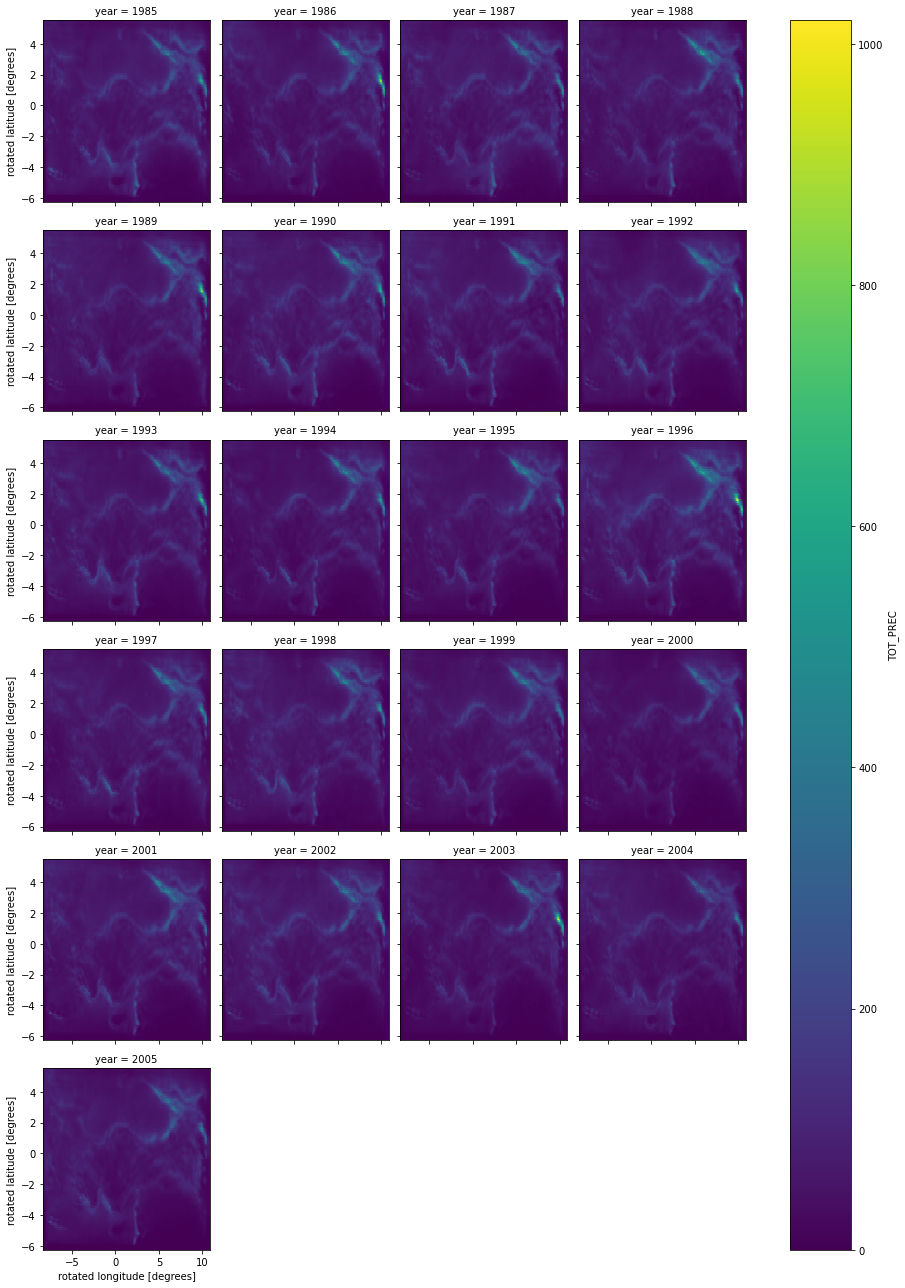

In [100]:
dt_model_annualmean_clim[name_var].plot(col='year',
                                      col_wrap=4)

### 5.2 Observation Data

#### 5.2.1 Monthly Mean

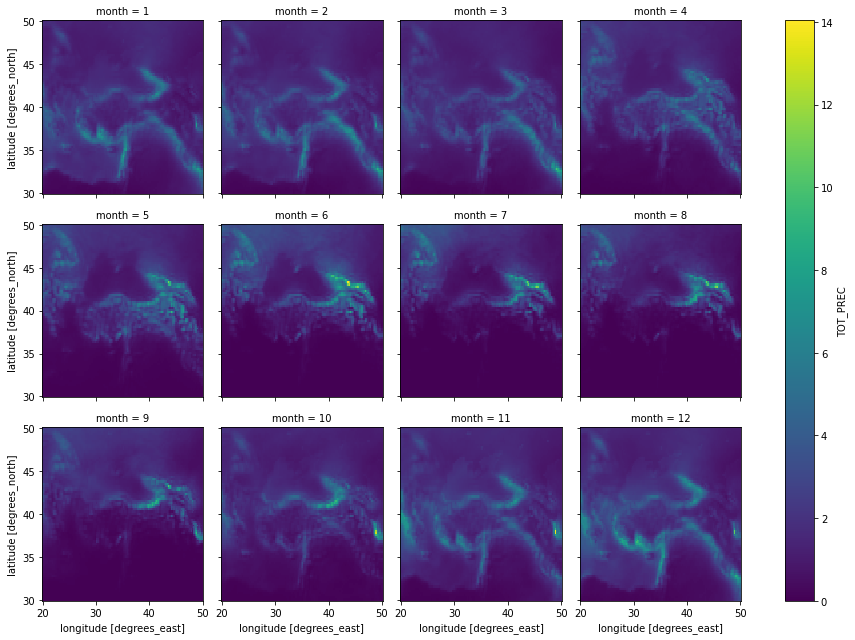

In [94]:
dt_obs_monmean_clim[name_var].plot(col='month',
                                   col_wrap=4)

#### 5.2.2 Seasonally Mean

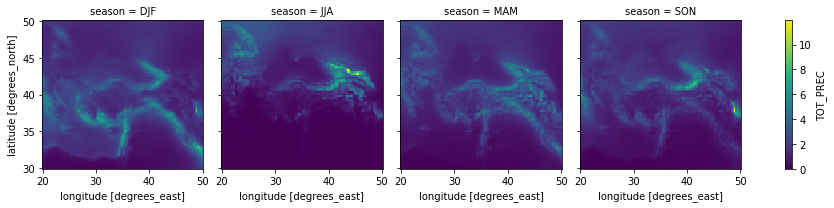

In [96]:
dt_obs_seasonmean_clim[name_var].plot(col='season',
                                      col_wrap=4)

#### 5.2.3 Annual Mean

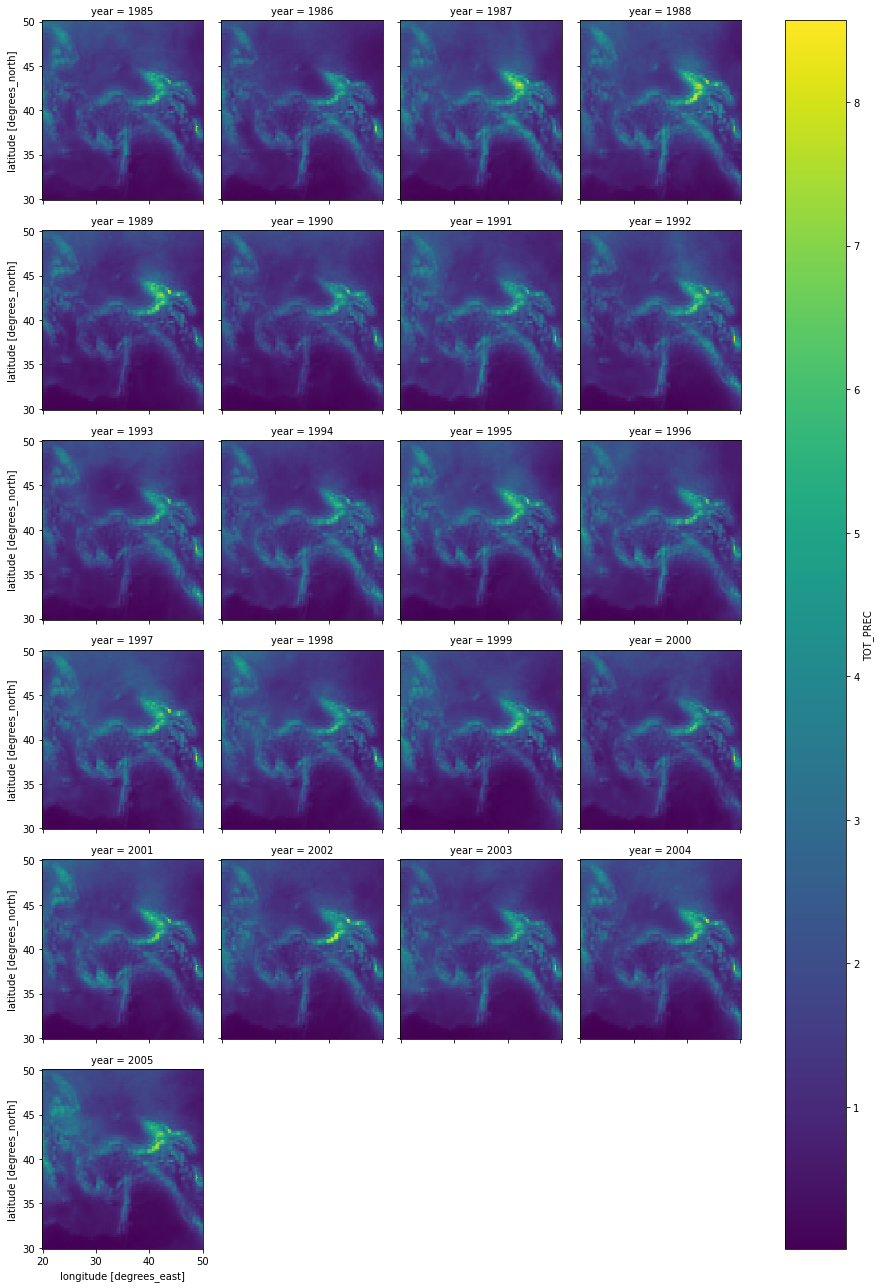

In [97]:
dt_obs_annualmean_clim[name_var].plot(col='year',
                                      col_wrap=4)